In [32]:
import pennylane as qml
import tensorflow as tf
import sklearn.datasets
import numpy as np

from myutils import Datasets
from myutils import Preprocessing
from myutils import Helpers
from matplotlib import pyplot as plt

# Import and Preprocess Data

In [23]:
data_new= Datasets.get_preprocessed_datasets("RAW")["RAW"]["6,9"]

#convert to binary -> nur schwarz oder weiss 
x_train , x_test = data_new["x_train"] / 255, data_new["x_test"] / 255
x_train , x_test = np.rint(x_train), np.rint(x_test)

x_train_pca, x_test_pca = Preprocessing.PCA(x_train,x_test,outputsize=4)

#scale data 0, 2*np
data_new["x_train_pca"] = Preprocessing.minmax_scaler(x_train_pca, min = 0,max = 2 * np.pi)
data_new["x_test_pca"] = Preprocessing.minmax_scaler(x_test_pca, min = 0,max = 2 * np.pi)

In [24]:
n = 1000
split = 0.75
data_new["x_train_pca"] = data_new["x_train_pca"][:int(n*split)]
data_new["y_train_binary"] = data_new["y_train_binary"][:int(n*split)]
data_new["x_test_pca"] = data_new["x_test_pca"][:int(n*(1-split))]
data_new["y_test_binary"] = data_new["y_test_binary"][:int(n*(1-split))]

print("train {}, test{}".format(int(n*split),int(n*(1-split))))

train 750, test250


In [25]:
n_qubits = 4
wires = 4
layers = 4
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.embeddings.AngleEmbedding(
        features=inputs, wires=range(wires), rotation="X"
    )
    for layer in range(layers):
        for wire in range(wires):
            qml.RX(weights[layer][wire][0], wires=wire)
            qml.RY(weights[layer][wire][1], wires=wire)
        for wire in range(0, wires - 1, 2):
            qml.CZ(wires=[wire, wire + 1])
        for wire in range(1, wires - 1, 2):
            qml.CZ(wires=[wire, wire + 1])
    return qml.expval(qml.PauliZ(0)), qml.expval(qml.PauliZ(1))

In [26]:
weight_shapes = {"weights": (4, n_qubits, 4)}

qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=2)
clayer1 = tf.keras.layers.Dense(n_qubits)
clayer2 = tf.keras.layers.Dense(2, activation="softmax")
model = tf.keras.models.Sequential([clayer1, qlayer, clayer2])


X = tf.constant(data_new["x_train_pca"], dtype=tf.float32)
Y = tf.one_hot(data_new["y_train_binary"], 2)

X_test = tf.constant(data_new["x_test_pca"], dtype=tf.float32)
Y_test = tf.one_hot(data_new["y_test_binary"], 2)


opt = tf.keras.optimizers.Adam()
model.compile(opt, loss=tf.keras.losses.BinaryCrossentropy(), metrics=["accuracy"])

In [28]:
%%time
tf.compat.v1.reset_default_graph()
with tf.device("/device:GPU:0"):
    hist = model.fit(X, Y, epochs=5, batch_size=7, validation_data=(X_test, Y_test))

Epoch 1/5
108/108 [==============================] - 411s 4s/step - loss: 0.5091 - accuracy: 0.8093 - val_loss: 0.4777 - val_accuracy: 0.8600
Epoch 2/5
108/108 [==============================] - 424s 4s/step - loss: 0.4120 - accuracy: 0.9093 - val_loss: 0.4029 - val_accuracy: 0.9240
Epoch 3/5
108/108 [==============================] - 404s 4s/step - loss: 0.3704 - accuracy: 0.9307 - val_loss: 0.3644 - val_accuracy: 0.9480
Epoch 4/5
108/108 [==============================] - 371s 3s/step - loss: 0.3353 - accuracy: 0.9467 - val_loss: 0.3312 - val_accuracy: 0.9720
Epoch 5/5
108/108 [==============================] - 376s 3s/step - loss: 0.3047 - accuracy: 0.9573 - val_loss: 0.3102 - val_accuracy: 0.9720
CPU times: user 16min 8s, sys: 12min 43s, total: 28min 52s
Wall time: 33min 5s


In [31]:
Helpers.store(hist.history,"measure/QML_TF/","hist")

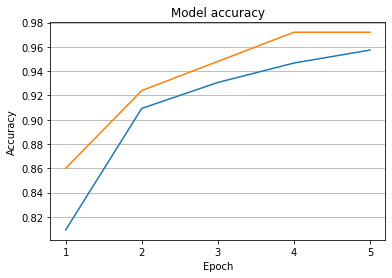

In [52]:
plt.plot(np.array(range(1,6)),hist.history["accuracy"],label="accuracy")
plt.plot(np.array(range(1,6)),hist.history["val_accuracy"],label="val_accuracy")
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xticks(np.array(range(1,6)),["1","2","3","4","5"])
plt.xlabel("Epoch")
plt.grid(axis="y")
plt.show()